In [183]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.simplefilter("ignore", FutureWarning)

import xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import xclone.lib.pandas_utils
import xclone.lib.system_utils
from xclone.lib.workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="quality_control",
    experiment_info={"sample" : "STP_GT", 
                     "modality" : "scDNA"},
    verbose=True
)
workspace.load_workspace()
print(workspace.experiment_info)
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'modality': 'scDNA', 'sample': 'STP_GT'}


In [184]:
data = {
    data_type : xclone.lib.system_utils.pickle_load(
        workspace.tmp_data[data_type]
    )
    for data_type in ["ase", "clustering", "blocks", "scCNV", "bin_counts"]
}
data["scCNV"].sort_values(by=["CHROM", "START", "END"]).reset_index(drop=True)
data["scCNV"].fillna(inplace=True, method="ffill")
data["scCNV_CNV_kit"] = xclone.lib.system_utils.pickle_load(
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone"
    "/data/processed/STP_GT/scDNA/cell_block_cnv.pkl"
).sort_values(by=["CHROM", "START", "END"]).reset_index(drop=True)
data["scCNV_CNV_kit"].fillna(inplace=True, method="ffill")

In [185]:
%%time
chisel_cnv_df = data["scCNV"].drop(columns=["CHROM", "START", "END"]).apply(
    lambda acnv_profile: [sum([int(x) for x in s.split(" ")[-1].split("|")])
                          for s in acnv_profile]
)
chisel_cnv_df[chisel_cnv_df > 6] = 6
cnvkit_cnv_df = data["scCNV_CNV_kit"].drop(columns=["CHROM", "START", "END"])
cnvkit_cnv_df[cnvkit_cnv_df > 6] = 6
print("Computed total copy numbers")
chisel_cnv_description = chisel_cnv_df.describe()
a_cn_df =  data["scCNV"].drop(columns=["CHROM", "START", "END"]).apply(
    lambda acnv_profile: [float(s.split(" ")[-1].split("|")[1])
                          for s in acnv_profile]
)
b_cn_df = chisel_cnv_df - a_cn_df
perfect_asr_df = data["scCNV"].drop(columns=["CHROM", "START", "END"]).apply(
    lambda acnv_profile: [float(s.split(" ")[-1].split("|")[1])
                          for s in acnv_profile]
) / chisel_cnv_df

print("Computed perfect ASRs")
dp_df = xclone.lib.pandas_utils.extract_counts(data["bin_counts"])
ad_df = xclone.lib.pandas_utils.extract_counts(data["bin_counts"], "ad")

mismatch_count = 0
for cell_id in tqdm_notebook(range(dp_df.shape[1]), "phasing alellic counts"):
    for block_id in range(dp_df.shape[0]):
        a_cn = a_cn_df.iloc[block_id, cell_id]
        b_cn = b_cn_df.iloc[block_id, cell_id]
        b_cnt = ad_df.iloc[block_id, cell_id]
        a_cnt = dp_df.iloc[block_id, cell_id] - b_cnt
        if (a_cn < b_cn) ^ (a_cnt < b_cnt):
            mismatch_count += 1
            ad_df.iloc[block_id, cell_id] = a_cnt
print(mismatch_count)

actual_asr_df = pd.DataFrame(
    1 - ad_df.values / dp_df.values, 
    columns=xclone.lib.pandas_utils.extract_barcodes(ad_df)
)

print("Computed actual ASRs")
baf_df = data["ase"].drop(columns=["CHROM", "START", "END"])
print("Computed BAFs")

Computed total copy numbers
Computed perfect ASRs


/icgc/dkfzlsdf/analysis/B260/users/v390v/.conda/envs/xclone/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/icgc/dkfzlsdf/analysis/B260/users/v390v/.conda/envs/xclone/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/icgc/dkfzlsdf/analysis/B260/users/v390v/.conda/envs/xclone/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide



26589
Computed actual ASRs
Computed BAFs
CPU times: user 20 s, sys: 1.19 s, total: 21.2 s
Wall time: 18.4 s


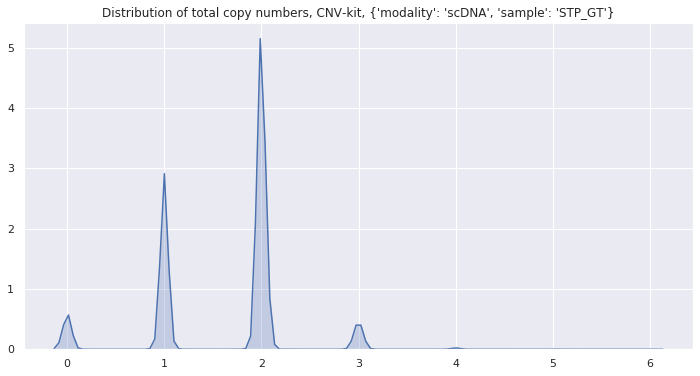

In [186]:
plt.figure(figsize=(12,6))
plt.title(f"Distribution of total copy numbers, CNV-kit, {workspace.experiment_info}")
sns.kdeplot(
    np.ravel(cnvkit_cnv_df.values), 
    legend=False, shade=True
);

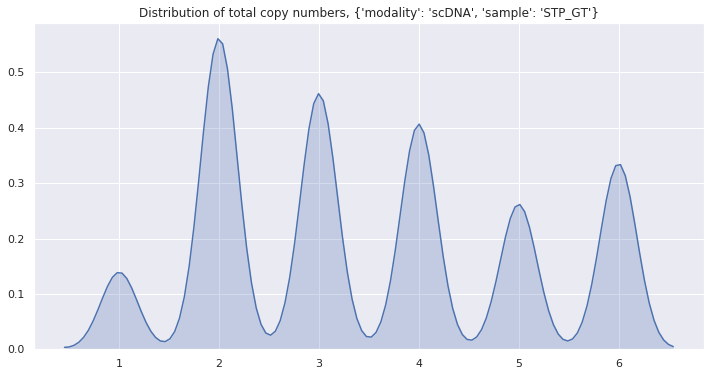

In [187]:
plt.figure(figsize=(12,6))
plt.title(f"Distribution of total copy numbers, {workspace.experiment_info}")
sns.kdeplot(np.ravel(chisel_cnv_df.values), legend=False, shade=True);

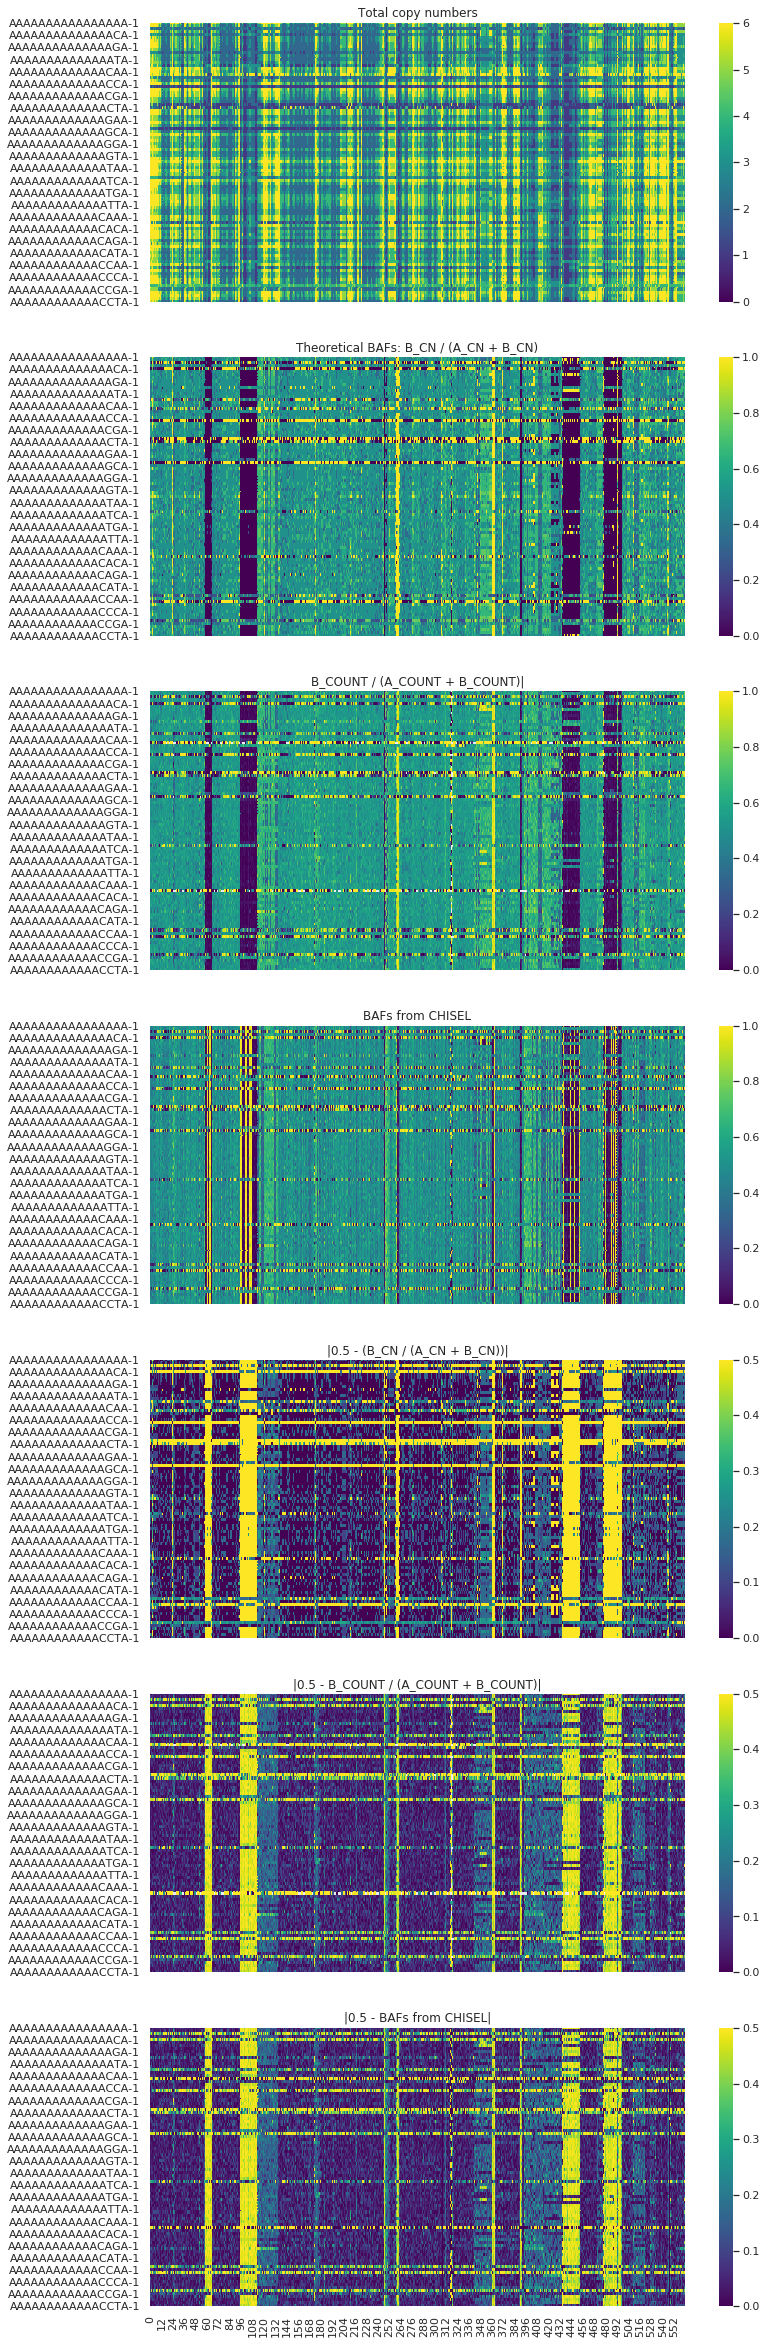

In [188]:
n_figures = 7
fig, axes = plt.subplots(
    n_figures, 1, 
    figsize=(12, 6 * n_figures), 
    sharex=True
);

axes[0].set_title("Total copy numbers")
sns.heatmap(
    total_cnv_df.T, 
    cmap="viridis", 
    vmin=0,
    vmax=6,
    ax=axes[0]
);

axes[1].set_title("Theoretical BAFs: B_CN / (A_CN + B_CN)")
sns.heatmap(
    perfect_asr_df.T, 
    cmap="viridis", 
    vmin=0,
    vmax=1,
    ax=axes[1]
);

axes[2].set_title("B_COUNT / (A_COUNT + B_COUNT)|")
sns.heatmap(
    actual_asr_df.T, 
    cmap="viridis", 
    vmin=0,
    vmax=1,
    ax=axes[2]
);

axes[3].set_title("BAFs from CHISEL")
sns.heatmap(
    baf_df.T, 
    cmap="viridis", 
    vmin=0,
    vmax=1,
    ax=axes[3]
);

axes[4].set_title("|0.5 - (B_CN / (A_CN + B_CN))|")
sns.heatmap(
    np.abs(0.5 - perfect_asr_df.T), 
    cmap="viridis", 
    vmin=0,
    vmax=0.5,
    ax=axes[4]
);

axes[5].set_title("|0.5 - B_COUNT / (A_COUNT + B_COUNT)|")
sns.heatmap(
    np.abs(0.5 - actual_asr_df.T), 
    cmap="viridis", 
    vmin=0,
    vmax=0.5,
    ax=axes[5]
);

axes[6].set_title("|0.5 - BAFs from CHISEL|")
sns.heatmap(
    np.abs(0.5 - baf_df.T), 
    cmap="viridis", 
    vmin=0,
    vmax=0.5,
    ax=axes[6]
);

In [ ]:
        import matplotlib.colors

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [157]:
def plot_cnv_clustermap(cnv_df, segment_annot_df, title, cnv_cmap):
    chrom_palette = sns.color_palette("coolwarm", 22)
    chrom_to_color = dict(zip(np.arange(22) + 1, chrom_palette))

    g = sns.clustermap(
        cnv_df, 
        cmap=cnv_cmap,#"viridis", 
        vmin=0,
        vmax=6,
        col_cluster=False,
    #     row_cluster=False,
    #     col_colors=data["scCNV_CNV_kit"]["CHROM"].apply(chrom_to_color.get),
        figsize=(24, 12)
    )
    # g.fig.suptitle("Total copy numbers, CNV-kit");
    g.ax_heatmap.set_title(title, fontsize=24, fontweight="bold")
    g.ax_heatmap.set_xticklabels([]);
    g.ax_heatmap.set_yticklabels([]);

    chrom_endpoint_indices = []
    xticks = []
    xticklabels = []
    for chrom_id, chrom_blocks in segment_annot_df.groupby("CHROM"):
        first_block_id = chrom_blocks.index.min()
        last_block_id = chrom_blocks.index.max()
        chrom_endpoint_indices.append([
            [chrom_id,  first_block_id, last_block_id]
        ])
        g.ax_heatmap.axvline(chrom_blocks.index.max(), linestyle="--", color="black")
        xticks.append((first_block_id + last_block_id) // 2)
        xticklabels.append(chrom_id)

    g.ax_heatmap.set_xticks(xticks)
    g.ax_heatmap.set_xlabel("chromosomes", fontweight="bold", fontsize=18)
    g.ax_heatmap.set_ylabel("cells", fontweight="bold", fontsize=18)
    g.ax_heatmap.set_xticklabels(xticklabels, fontweight="bold", rotation=0);

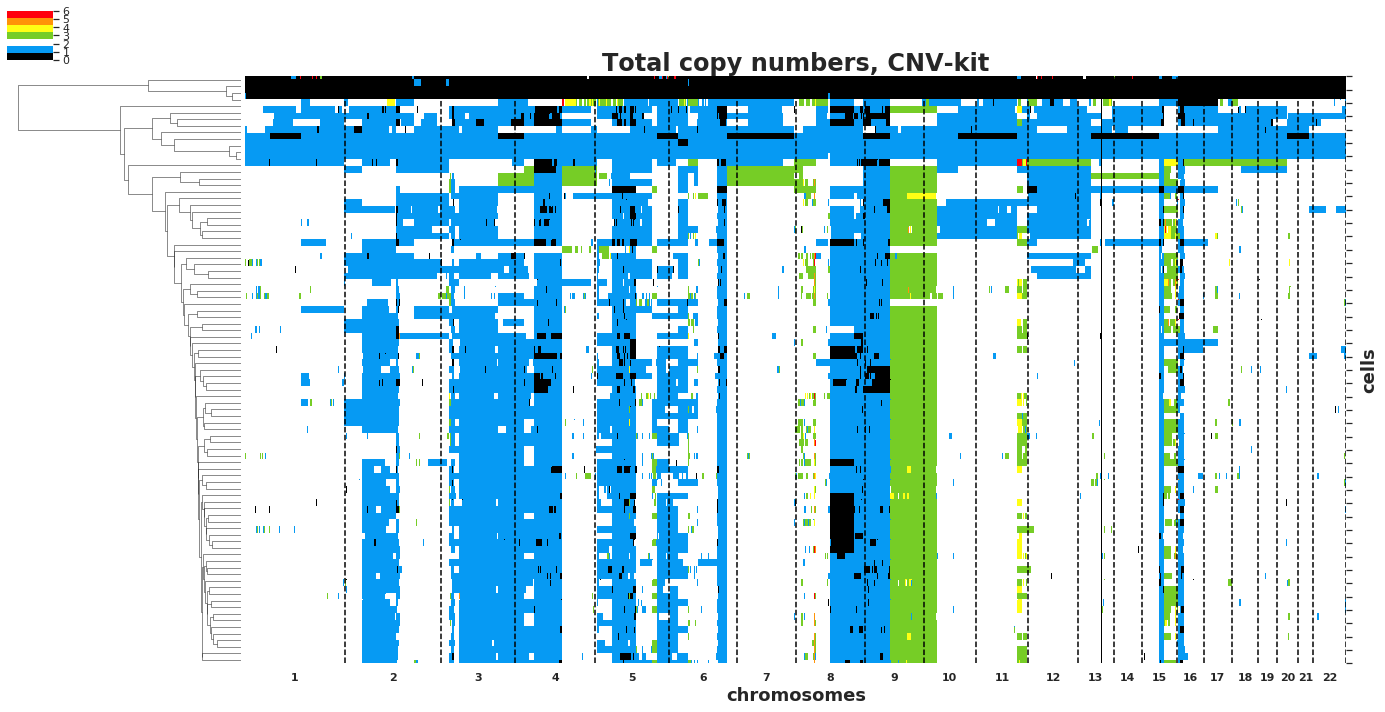

In [158]:
cnv_cmap = matplotlib.colors.ListedColormap([
    'xkcd:black', 
    'xkcd:azure',
    'xkcd:white', 
    "xkcd:apple green",
    "xkcd:yellow",
    'xkcd:tangerine',
    'xkcd:bright red'
])
plot_cnv_clustermap(
    cnv_df=cnvkit_cnv_df.T, 
    segment_annot_df=data["scCNV_CNV_kit"][["CHROM", "START", "END"]],
    title="Total copy numbers, CNV-kit",
    cnv_cmap=cnv_cmap
)

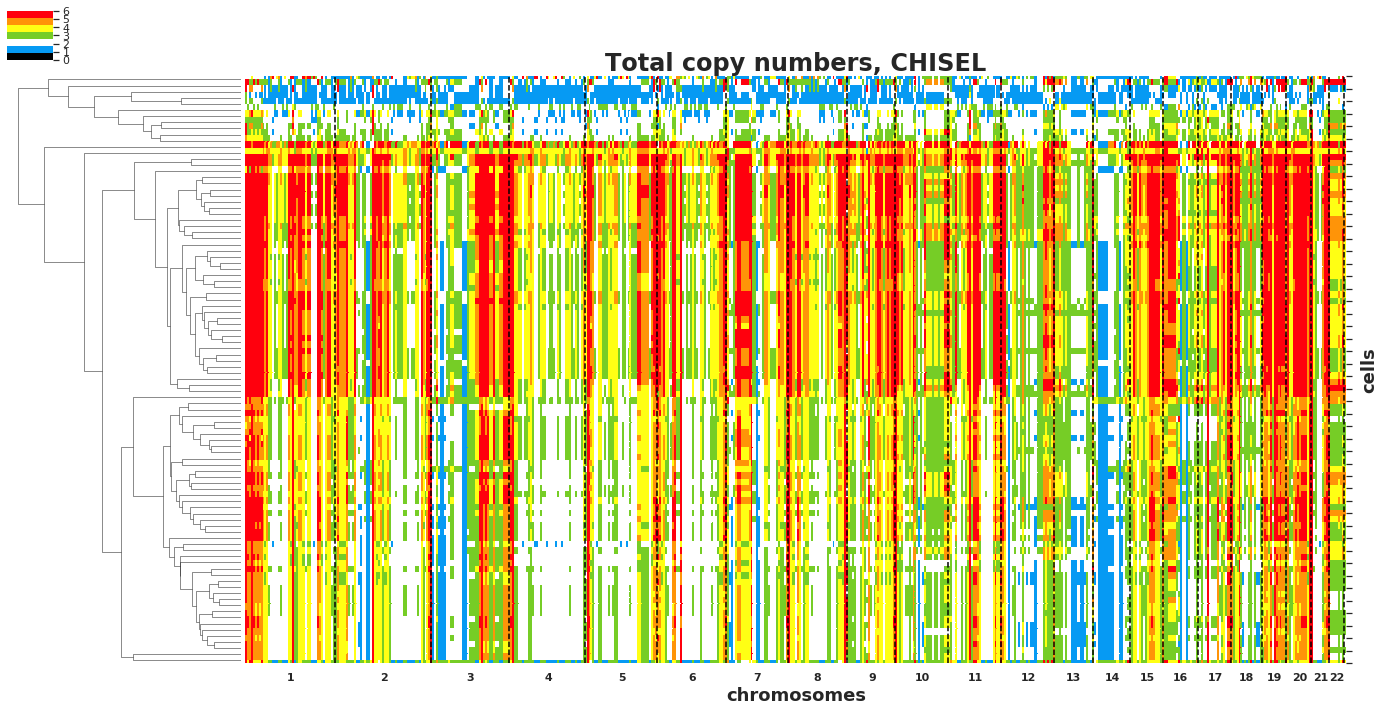

In [159]:
plot_cnv_clustermap(
    cnv_df=chisel_cnv_df.T, 
    segment_annot_df=data["scCNV"][["CHROM", "START", "END"]],
    title="Total copy numbers, CHISEL",
    cnv_cmap=cnv_cmap
)

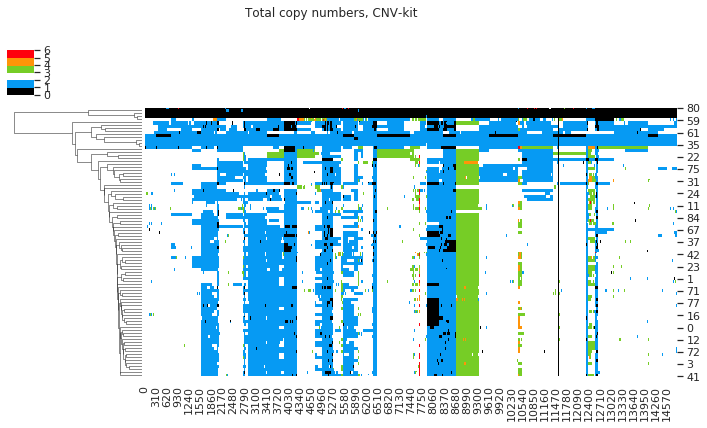

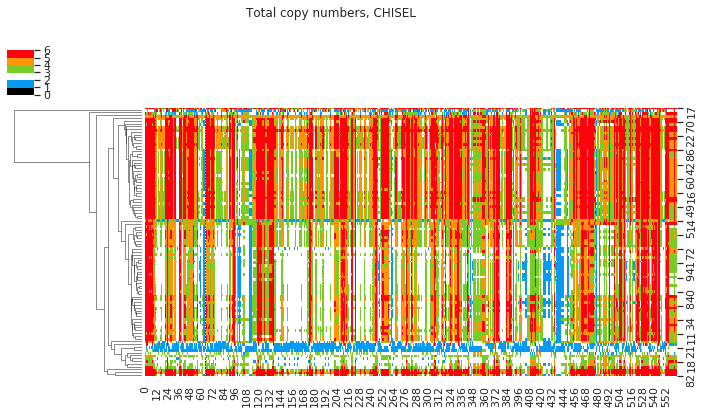

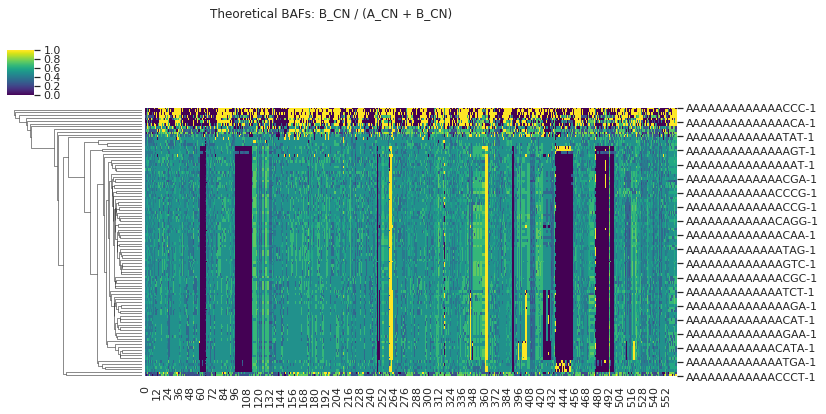

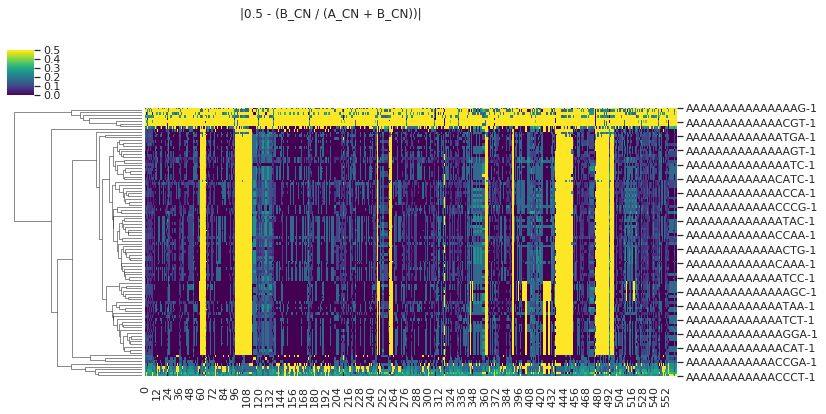

In [49]:
sns.clustermap(
    perfect_asr_df.fillna(0).T, 
    cmap="viridis", 
    vmin=0,
    vmax=1,
    col_cluster=False,
    figsize=(12, 6)
).fig.suptitle("Theoretical BAFs: B_CN / (A_CN + B_CN)")

sns.clustermap(
    np.abs(0.5 - perfect_asr_df.fillna(0).T), 
    cmap="viridis", 
    vmin=0,
    vmax=0.5,
    col_cluster=False,
    figsize=(12, 6)
).fig.suptitle("|0.5 - (B_CN / (A_CN + B_CN))|");

In [ ]:
import umap